In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dog-breed-identification/sample_submission.csv
/kaggle/input/dog-breed-identification/labels.csv
/kaggle/input/dog-breed-identification/test/09e51e17e2b756ff2ace8a87bd1443fa.jpg
/kaggle/input/dog-breed-identification/test/f7a32505c12649183c5991ecfa7d68b3.jpg
/kaggle/input/dog-breed-identification/test/bc6d50ffb4644feb34530aa58943e85b.jpg
/kaggle/input/dog-breed-identification/test/7cbc041e79135a572aad87904b5c9c57.jpg
/kaggle/input/dog-breed-identification/test/f3b603f10d6a344f0395fb46b242ff8e.jpg
/kaggle/input/dog-breed-identification/test/db55098d859d27a3c05b0e3fc41d43e7.jpg
/kaggle/input/dog-breed-identification/test/665bab06a3ea861c0812c778486988e3.jpg
/kaggle/input/dog-breed-identification/test/7b57911ea7559cebd6db308125926642.jpg
/kaggle/input/dog-breed-identification/test/df0d6ba158287cb2b3ed6459a22d42ba.jpg
/kaggle/input/dog-breed-identification/test/b80d89ad4a17ac2537ff46d251efcd7c.jpg
/kaggle/input/dog-breed-identification/test/06ecb29a374579fb320c1c7d2801cbe1.jp

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
import itertools 
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
train_dir = '../input/dog-breed-identification/train'
test_dir ='../input/dog-breed-identification/test'

In [4]:
def append_ext(fn):
    return fn+".jpg"

In [5]:
traindf = pd.read_csv('../input/dog-breed-identification/labels.csv',dtype=str)
testdf = pd.read_csv('../input/dog-breed-identification/sample_submission.csv',dtype=str)

In [6]:
traindf["breed"].values

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [7]:
traindf["id"] = traindf["id"].apply(append_ext)
testdf["id"] = testdf["id"].apply(append_ext)

In [8]:
included_breed = ['beagle', 'chihuahua', 'doberman',
'french_bulldog', 'golden_retriever', 'malamute', 'pug', 'saint_bernard', 'scottish_deerhound',
'tibetan_mastiff']
for index,breed in traindf.iterrows():
    if breed[1] not in included_breed:
        traindf= traindf.drop([index])
traindf.shape

(841, 2)

In [9]:
print(traindf.shape)
print(traindf.head())

(841, 2)
                                      id               breed
4   0021f9ceb3235effd7fcde7f7538ed62.jpg    golden_retriever
9   0042188c895a2f14ef64a918ed9c7b64.jpg  scottish_deerhound
20  008b1271ed1addaccf93783b39deab45.jpg            doberman
25  00a366d4b4a9bbb6c8a63126697b7656.jpg    golden_retriever
37  0100f55e4f0fe28f2c0465d3fc4b9897.jpg    golden_retriever


In [10]:
print(testdf.shape)
print(testdf.head())

(10357, 121)
                                     id        affenpinscher  \
0  000621fb3cbb32d8935728e48679680e.jpg  0.00833333333333333   
1  00102ee9d8eb90812350685311fe5890.jpg  0.00833333333333333   
2  0012a730dfa437f5f3613fb75efcd4ce.jpg  0.00833333333333333   
3  001510bc8570bbeee98c8d80c8a95ec1.jpg  0.00833333333333333   
4  001a5f3114548acdefa3d4da05474c2e.jpg  0.00833333333333333   

          afghan_hound  african_hunting_dog             airedale  \
0  0.00833333333333333  0.00833333333333333  0.00833333333333333   
1  0.00833333333333333  0.00833333333333333  0.00833333333333333   
2  0.00833333333333333  0.00833333333333333  0.00833333333333333   
3  0.00833333333333333  0.00833333333333333  0.00833333333333333   
4  0.00833333333333333  0.00833333333333333  0.00833333333333333   

  american_staffordshire_terrier          appenzeller   australian_terrier  \
0            0.00833333333333333  0.00833333333333333  0.00833333333333333   
1            0.00833333333333333  0.0

# Looking at some images

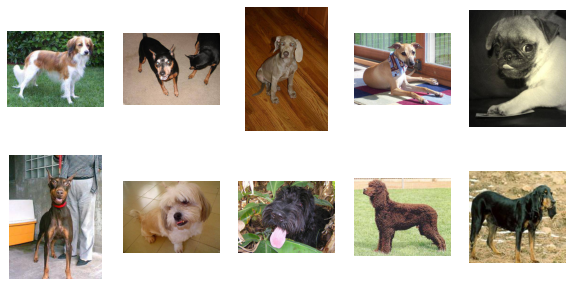

In [11]:
import os 
src_path = "../input/dog-breed-identification/train"
sub_class = os.listdir(src_path)

fig = plt.figure(figsize=(10,5))
for e in range(len(sub_class[:10])):
    plt.subplot(2,5,e+1)
    img = plt.imread(os.path.join(src_path,sub_class[e]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis('off')

In [12]:
train_datagen=ImageDataGenerator( rescale=1./255.,
                                  rotation_range = 20,
                                  brightness_range=[0.2,1.0],
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  #shear_range = 0.2,
                                  #zoom_range = [0.7,1],
                                  horizontal_flip = True,
                                  #Setting validation split to 2% 
                                  validation_split=0.1
                                  )

In [13]:
BATCH_SIZE = 32
image_size=(224,224)

In [14]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=train_dir,
x_col="id",
y_col="breed",
subset="training",
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=image_size,
color_mode="rgb" 
)

Found 757 validated image filenames belonging to 10 classes.


# Looking at augemnted images

In [15]:
x,y = next(train_generator)

In [16]:
print(type(x))
print(x.shape)
print(y.shape)

<class 'numpy.ndarray'>
(32, 224, 224, 3)
(32, 10)


In [17]:
def show_grid(image_list,nrows,ncols,figsize=(10,10),showaxis='off'):
    
    image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        

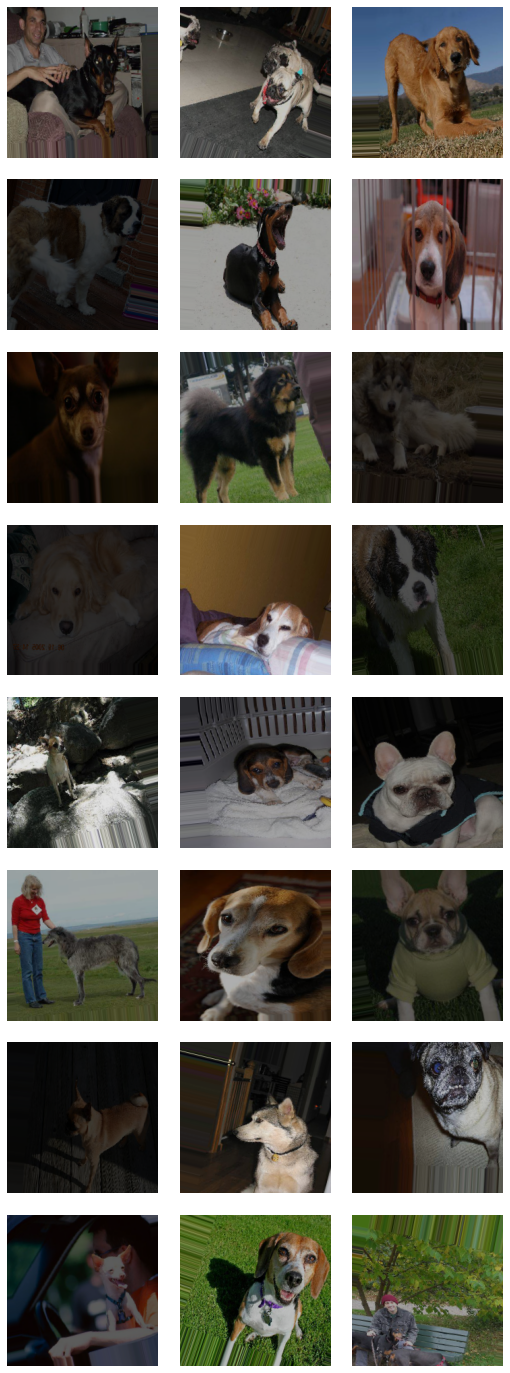

In [18]:
show_grid(x,8,3,figsize=(25,25))

In [19]:
valid_generator=train_datagen.flow_from_dataframe(
dataframe=traindf,
directory=train_dir,
x_col="id",
y_col="breed",
subset="validation",
batch_size=BATCH_SIZE,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=image_size,
color_mode="rgb")

Found 84 validated image filenames belonging to 10 classes.


In [20]:
test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory=test_dir,
x_col="id",
y_col=None,
batch_size=BATCH_SIZE,
seed=42,
shuffle=False,
class_mode=None,
target_size=image_size,
color_mode="rgb")

Found 10357 validated image filenames.


In [21]:
shape=(224,224,3)
classes = len(included_breed)
classes

10

# ResNet50 pretrained model

In [22]:
pretrained_model = tf.keras.applications.ResNet50V2(
        weights='imagenet',
        include_top=False ,
        input_shape=shape
    )

# pretrained_model.trainable = False
    
model = tf.keras.Sequential([ 
        pretrained_model,  
        tf.keras.layers.Flatten(),
#         tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(2048, activation='relu'),
        tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(512, activation='relu'),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
    
        tf.keras.layers.Dense(10, activation='softmax')
    ])

94674944/94668760 [==============================] - 3s 0us/step


In [23]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred): 
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# compile the model

# fit the model
# history = model.fit(Xtrain, ytrain, validation_split=0.3, epochs=10, verbose=0)

In [24]:
opt=tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer= opt , loss='categorical_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              205522944 
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                1

In [25]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
                   )

Epoch 1/10
23/23 [==============================] - 33s 940ms/step - loss: 4.4334 - acc: 0.1636 - f1_m: 0.1371 - precision_m: 0.1780 - recall_m: 0.1128 - val_loss: 1.3133 - val_acc: 0.5469 - val_f1_m: 0.4540 - val_precision_m: 0.6722 - val_recall_m: 0.3438
Epoch 2/10
23/23 [==============================] - 17s 730ms/step - loss: 2.3702 - acc: 0.3300 - f1_m: 0.2991 - precision_m: 0.4439 - recall_m: 0.2281 - val_loss: 1.0221 - val_acc: 0.6875 - val_f1_m: 0.5745 - val_precision_m: 0.9000 - val_recall_m: 0.4219
Epoch 3/10
23/23 [==============================] - 16s 696ms/step - loss: 1.6916 - acc: 0.4371 - f1_m: 0.4290 - precision_m: 0.6253 - recall_m: 0.3280 - val_loss: 0.6973 - val_acc: 0.8594 - val_f1_m: 0.7614 - val_precision_m: 0.9773 - val_recall_m: 0.6250
Epoch 4/10
23/23 [==============================] - 17s 748ms/step - loss: 1.3702 - acc: 0.5123 - f1_m: 0.5051 - precision_m: 0.7310 - recall_m: 0.3900 - val_loss: 0.4800 - val_acc: 0.9062 - val_f1_m: 0.8623 - val_precision_m: 0.

In [26]:
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('MODEL '+ title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

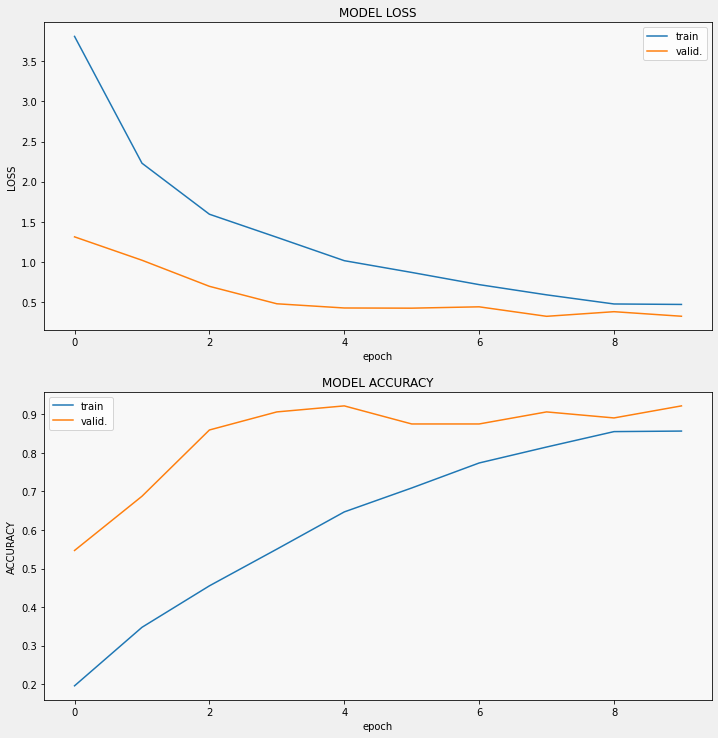

In [27]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'LOSS',
    211,
)

display_training_curves(
    history.history['acc'],
    history.history['val_acc'],
    'ACCURACY',
    212,
)

In [28]:
loss, accuracy, f1_score, precision, recall = model.evaluate(valid_generator,batch_size=32)
# score = model.evaluate(valid_generator,batch_size=32)
# print("Accuracy: {:.2f}%".format(score[1] * 100)) 
# print("Loss: ",score[0])

print("Loss:", loss)
print("Accuracy:", accuracy)
print("F1 Score:", f1_score)

3/3 [==============================] - 2s 575ms/step - loss: 0.2706 - acc: 0.9167 - f1_m: 0.9283 - precision_m: 0.9696 - recall_m: 0.8917
Loss: 0.2705622613430023
Accuracy: 0.9166666865348816
F1 Score: 0.9283291697502136


In [29]:
model.save("DogClassificationByResNet2.h5")

In [30]:
pred=model.predict(test_generator)

In [31]:
df_submission = pd.read_csv('/kaggle/input/dog-breed-identification/sample_submission.csv', usecols= included_breed+['id'])
df_submission.head()

,id,beagle,chihuahua,doberman,french_bulldog,golden_retriever,malamute,pug,saint_bernard,scottish_deerhound,tibetan_mastiff
0,000621fb3cbb32d8935728e48679680e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
1,00102ee9d8eb90812350685311fe5890,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
2,0012a730dfa437f5f3613fb75efcd4ce,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
3,001510bc8570bbeee98c8d80c8a95ec1,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333
4,001a5f3114548acdefa3d4da05474c2e,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333,0.008333


# Submission

In [32]:
df_submission.to_csv('Submission.csv')
